In [1]:
#Import the libraries we’ll need
import os
import shutil 
import pandas as pd
import keras
import numpy as np
from os import listdir
import tensorflow as tf
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,ZeroPadding2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers.normalization import layer_normalization
from keras.layers import Activation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import normalize
from sklearn import svm

In [2]:
#The function for processing dataset into tumor and non_tumor
def split_data_into_no_yes_dirs(dir):
  os.chdir(dir)
  train_csv = pd.read_csv("label.csv")
  #print(train_csv.head())
  directory = os.fsencode('image')
  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      index = train_csv.index[train_csv['file_name'] == filename]
      if train_csv.loc[index.values[0],'label']=="no_tumor":
          shutil.copy('image/'+filename, '/content/drive/MyDrive/AMLS/dataset/no')
      else:
          shutil.copy('image/'+filename, '/content/drive/MyDrive/AMLS/dataset/yes')

In [3]:
#Invoke the previous function

# mount google drive to load the dataset uploaded on it 
from google.colab import drive
drive.mount('/content/drive')

#split_data_into_no_yes_dirs("/content/drive/MyDrive/AMLS/dataset")

Mounted at /content/drive


In [4]:
#The function for loading training data
def load_train_data(dir):
    X = []
    y = []
    os.chdir(dir)
    dirs = ['yes', "no"]
    for directory in dirs:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = cv2.resize(image, dsize=(240,240))
            X.append(image)
            if directory == 'yes':
                y.append([1])
            elif directory == 'no':
                y.append([0])
            else:
              print("Wrong! ")
    X = np.array(X)
    X = normalize(X, axis=1)
    y = np.array(y)
    return X, y

In [5]:
#Invoke the previous function
data_dir ="/content/drive/MyDrive/AMLS/dataset"
X, y = load_train_data(data_dir)

print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

Number of examples is: 3000
X shape is: (3000, 240, 240, 3)
y shape is: (3000, 1)


In [6]:
#Divide the dataset
X_train , X_test, y_train, y_test = train_test_split(X , y , test_size = 0.1, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.1, random_state = 42)

In [7]:
#The function for building the CNN model for task A
def build_model():
  tf.keras.backend.clear_session()
  model= Sequential()
  model.add(Conv2D(128, kernel_size =(6,6),padding='same', input_shape=(240,240,3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(96, kernel_size =(6,6), padding='same', strides=[2,2]))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(units = 1, activation = 'sigmoid'))
  
  return model

In [8]:
#The function for getting accuracy metrics
def get_accuracy_metrics(X_test, y_test):
  print("Test Acc: ",model.evaluate(X_test, y_test, verbose=0)[1])

  pred = model.predict(X_test)
  print("Confusion Matrix : \n ",confusion_matrix(np.round(pred), y_test))
  print("\nprecision score:  ",precision_score(np.round(pred), y_test))
  print("\nrecall score: ",recall_score(np.round(pred), y_test))
  print("\nF1 Score: ",f1_score(np.round(pred), y_test))

In [13]:
#The function for ploting learning curves
def plot_learning_curves(history):  
  train_loss = history['loss']
  val_loss = history['val_loss']
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']

  plt.figure()
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

In [14]:
#Train the CNN model for task A
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
76/76 [==============================] - 11s 132ms/step - loss: 2.0776 - accuracy: 0.8560 - val_loss: 26.2666 - val_accuracy: 0.2296
Epoch 2/20
76/76 [==============================] - 9s 115ms/step - loss: 0.9596 - accuracy: 0.9115 - val_loss: 25.3588 - val_accuracy: 0.2296
Epoch 3/20
76/76 [==============================] - 9s 115ms/step - loss: 0.8186 - accuracy: 0.9198 - val_loss: 22.8481 - val_accuracy: 0.2296
Epoch 4/20
76/76 [==============================] - 9s 115ms/step - loss: 0.4462 - accuracy: 0.9461 - val_loss: 7.4955 - val_accuracy: 0.2333
Epoch 5/20
76/76 [==============================] - 9s 115ms/step - loss: 0.3394 - accuracy: 0.9605 - val_loss: 3.4292 - val_accuracy: 0.5704
Epoch 6/20
76/76 [==============================] - 9s 114ms/step - loss: 0.2754 - accuracy: 0.9650 - val_loss: 0.8649 - val_accuracy: 0.8296
Epoch 7/20
76/76 [==============================] - 9s 115ms/step - loss: 0.2200 - accuracy: 0.9683 - val_loss: 1.5428 - val_accuracy: 0.7815
Ep

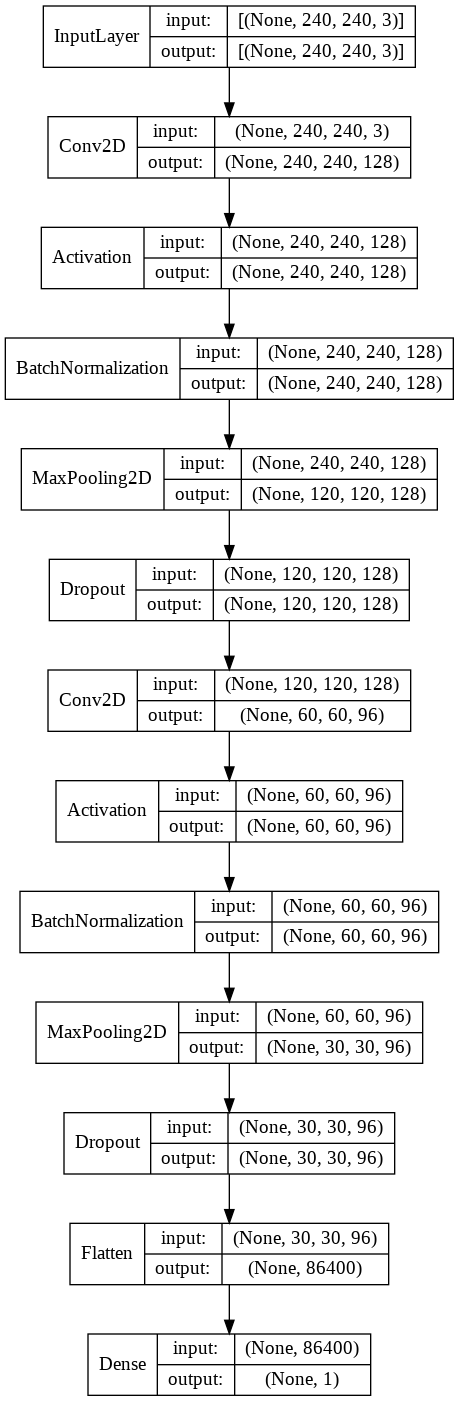

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=False)

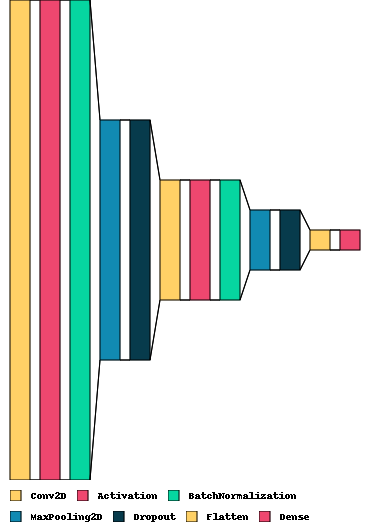

In [19]:
!pip install visualkeras

import visualkeras
from PIL import ImageFont
#model = build_model()
visualkeras.layered_view(model, legend=True,draw_volume=False, scale_xy=2,scale_z=0.000001) 

In [20]:
get_accuracy_metrics(X_test, y_test)

Test Acc:  0.9433333277702332
Confusion Matrix : 
  [[ 36  10]
 [  7 247]]

precision score:   0.9610894941634242

recall score:  0.9724409448818898

F1 Score:  0.9667318982387475


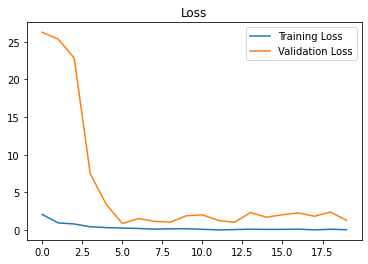

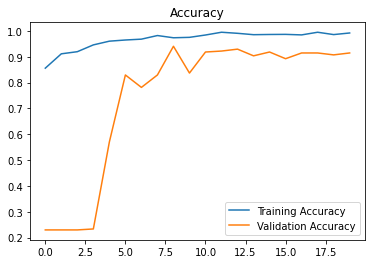

In [21]:
plot_learning_curves(history.history)

In [22]:
#The function for loading test data in order to provide scores
def load_test_data(dir):
  y_test = []
  X_test = [] 
  os.chdir(dir)

  y_test_csv = pd.read_csv('label.csv')
  image_name=y_test_csv['file_name'].to_list()
  label_name=y_test_csv['label'].to_list()
  for i in range(len(label_name)):  
    if label_name[i] == 'no_tumor':
        y_test.append(0)
    else:
        y_test.append(1)
  y_test=np.array(y_test)

  directory = "image"
  for i in range(len(image_name)):
      image = (directory+'/'+image_name[i])
      image = cv2.imread(image)
      image = cv2.resize(image,(240,240))
      X_test.append(image)
  X_test = np.array(X_test)
  X_test=normalize(X_test, axis=1)
  return X_test,y_test

In [23]:
dir = "/content/drive/MyDrive/AMLS/test"
X_test_data,y_test_data = load_test_data(dir)

In [24]:
get_accuracy_metrics(X_test_data, y_test_data)

Test Acc:  0.9449999928474426
Confusion Matrix : 
  [[ 34   8]
 [  3 155]]

precision score:   0.950920245398773

recall score:  0.9810126582278481

F1 Score:  0.9657320872274143


In [25]:
#SVM for task A

# creating an SVM Classifier
svc_classifier = svm.SVC(kernel='linear') # Linear Kernel
# training the model using the training sets
svc_classifier.fit(X_train.reshape(X_train.shape[0],240*240*3), y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [26]:
# predicting the response for test dataset
y_pred = svc_classifier.predict(X_test.reshape(X_test.shape[0],240*240*3))

In [27]:
# reporting model accuracy
print("Accuracy:", round(accuracy_score(y_test.ravel(), y_pred)*100),'%')
print("Confusion Matrix : \n ",confusion_matrix(y_pred, y_test))
print("\nprecision score:  ",precision_score(y_pred, y_test))
print("\nrecall score: ",recall_score(y_pred, y_test))
print("\nF1 Score: ",f1_score(y_pred, y_test))

Accuracy: 96 %
Confusion Matrix : 
  [[ 34   3]
 [  9 254]]

precision score:   0.9883268482490273

recall score:  0.9657794676806084

F1 Score:  0.9769230769230769
